In [12]:
from sympy import *
from sympy.abc import a,b,c
init_session()
import numpy as np
%matplotlib inline
from sympy import var

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



中心軸はP0を原点、軸がY軸に一致するように置かれていると仮定

In [13]:
bez,P0,P1,P2,P3 =symbols('bez,P0,P1,P2,P3')
# ベジエ曲線の一般式
bez =  (1-t)**3*P0 + 3*(1-t)**2*t*P1 + 3*(1-t)*t**2*P2 + t**3*P3
# ベジエ曲線の式に個別の制御点記号を代入して返す関数
def defbezf(CPs = [P0,P1,P2,P3]): 
    [p0,p1,p2,p3] = CPs
    return bez.subs([(P0,p0),(P1,p1),(P2,p2),(P3,p3)])
# 点レベル表現のベジエ定義式の点の記号に座標レベル表現にする関数　４点をまとめて指定
# def defbezM4(CPs=[[0,0],[0,0],[0,1],[0,1]]): 
#    [p0,p1,p2,p3] = CPs
#    return bez.subs([(P0,Matrix(p0)),(P1,Matrix(p1)),(P2,Matrix(p2)),(P3,Matrix(p3))])
#   （注意）Matrixを使う方が綺麗なのだが、simpifyがバグってるのでやむをえず 
def defbezM4(CPs=[[0,0],[0,0],[0,1],[0,1]]): 
    [[p0x,p0y],[p1x,p1y],[p2x,p2y],[p3x,p3y]] = CPs
    f1 = simplify(bez.subs([(P0,p0x),(P1,p1x),(P2,p2x),(P3,p3x)]))
    f2 = simplify(bez.subs([(P0,p0y),(P1,p1y),(P2,p2y),(P3,p3y)]))
    return Matrix([f1,f2])

In [14]:
# 点Pを(cx,cy)周りに r ラジアン回転
def rotation(P,r,cx,cy): 
    A1=Matrix(([1,0,-cx], [0,1,-cy],[0,0,1]))  #  center が原点になるように平行移動
    A2=Matrix(([cos(r),-sin(r),0], [sin(r),cos(r),0],[0,0,1])) # 原点周りに r ラジアン回転
    A3=Matrix(([1,0,cx], [0,1,cy],[0,0,1])) # 平行移動させた分だけ戻す
    A4=A3*A2*A1
    return (A4*Matrix([P[0],P[1],1]))[:2]

# 点列Plist 内の点をすべて (cx,cy)周りに r ラジアン回転
def rotationAll(Plist,r,cx,cy):
    return [rotation(P,r,cx,cy) for P in Plist]

# 平行移動
def move(P,dx,dy):
    return [P[0]+dx,P[1]+dy]    

# 点列全体の平行移動
def moveAll(Plist,dx,dy):
    return [move(P,dx,dy) for P in Plist]

In [17]:
# 制御点
pcx,pcy = symbols('pcx:4'),symbols('pcy:4')
plx,ply = symbols('plx:4'),symbols('ply:4')
prx,pry = symbols('prx:4'),symbols('pry:4')
px1,px2,px3 = symbols('px1,px2,px3')
py1,py2,py3 = symbols('py1,py2,py3')
CPC = [[0,0],[0,py1],[0,py2],[0,py3]]
CPL = [[0,0],[-px1,py1],[-px2,py2],[-px3,py3]]
CPR = [[0,0],[px1,py1],[px2,py2],[px3,py3]]
print('\n',CPC,'\n',CPL,'\n',CPR)


 [[0, 0], [0, py1], [0, py2], [0, py3]] 
 [[0, 0], [-px1, py1], [-px2, py2], [-px3, py3]] 
 [[0, 0], [px1, py1], [px2, py2], [px3, py3]]


In [5]:
#  CPC0,CPC1,CPL0,CPL1,CPR0,CPR1が CPC0 周りに a1 ラジアン回転、
# CPC3,CPC2,CPL3,CPL2,CPR3,CPR2 が CPC3 周りに a2 ラジアン回転　（　曲がりのモデル）
a0,a1,a2 = symbols('a0,a1,a2') 
x0,y0 = symbols('x0,y0') 
#QPC0,QPC1,QPL0,QPL1,QPR0,QPR1 ,QPC3,QPC2,QPL3,QPL2,QPR3,QPR2  は一時的な作業用変数
[QPC0,QPC1,QPL0,QPL1,QPR0,QPR1] = rotationAll([CPC[0],CPC[1],CPL[0],CPL[1],CPR[0],CPR[1]],a1,CPC[0][0],CPC[0][1])
[QPC3,QPC2,QPL3,QPL2,QPR3,QPR2] = rotationAll([CPC[3],CPC[2],CPL[3],CPL[2],CPR[3],CPR[2]],a2,CPC[3][0],CPC[3][1])
CPC,CPL,CPR = [QPC0,QPC1,QPC2,QPC3],[QPL0,QPL1,QPL2,QPL3],[QPR0,QPR1,QPR2,QPR3]
#  # 制御点全体が (x0,y0)だけ平行移動し、 (x0,y0)を中心として a0 ラジアン回転した結果が観測されている
CPC = rotationAll(moveAll(CPC,x0,y0),a0,x0,y0)
CPL = rotationAll(moveAll(CPL,x0,y0),a0,x0,y0)
CPR = rotationAll(moveAll(CPR,x0,y0),a0,x0,y0)

In [6]:
def drawModel(x,y,CCtl,LCtl,RCtl,angle0=0,angle1=0,angle2=0,dx=0,dy=0):
    bezASC = defbezM4(CPs=CCtl)
    bezASC = bezASC.subs([(px1,x[0]),(px2,x[1]),(px3,x[2])])
    bezASC = bezASC.subs([(py1,y[0]),(py2,y[1]),(py3,y[2])])
    bezASC = bezASC.subs([(a0,angle0),(a1,angle1),(a2,angle2),(x0,dx),(y0,dy)])
    
    bezASL = defbezM4(CPs=LCtl)
    bezASL = bezASL.subs([(px1,x[0]),(px2,x[1]),(px3,x[2])])
    bezASL = bezASL.subs([(py1,y[0]),(py2,y[1]),(py3,y[2])]) 
    bezASL = bezASL.subs([(a0,angle0),(a1,angle1),(a2,angle2),(x0,dx),(y0,dy)])

    bezASR = defbezM4(CPs=RCtl)
    bezASR = bezASR.subs([(px1,x[0]),(px2,x[1]),(px3,x[2])])
    bezASR = bezASR.subs([(py1,y[0]),(py2,y[1]),(py3,y[2])])
    bezASR = bezASR.subs([(a0,angle0),(a1,angle1),(a2,angle2),(x0,dx),(y0,dy)])

    tplins = np.linspace(0, 1,50)
    tslins11 = np.linspace(0, 1,11)
    plt.gca().set_aspect('equal', adjustable='box')
    for bezline in [bezASL,bezASC,bezASR]:
        f=simplify(bezline)
        plotx = np.array([bezline[0].subs(t,tp) for tp in tplins ])
        ploty = np.array([bezline[1].subs(t,tp) for tp in tplins ])
        plot11x = np.array([bezline[0].subs(t,tp) for tp in tslins11 ])
        plot11y = np.array([bezline[1].subs(t,tp) for tp in tslins11 ])
        plt.scatter(plot11x,plot11y)
        plt.plot(plotx,ploty)
    
    return bezASL,bezASC,bezASR

⎛⎡          3      2                                                       2  
⎜⎢    9.45⋅t  + 3⋅t ⋅(-9.4 - 0.3⋅√3)⋅(t - 1) - 3⋅t⋅(-9.9 + 0.15⋅√3)⋅(t - 1)  -
⎜⎢                                                                            
⎜⎢ 3                    2                                                     
⎝⎣t ⋅(0.45⋅√3 + 5) + 3⋅t ⋅(-4.7 - 0.4⋅√3)⋅(t - 1) - 3⋅t⋅(-5.15 + 0.1⋅√3)⋅(t - 

           3    ⎤  ⎡     3      2                                             
 10⋅(t - 1)     ⎥  ⎢9.5⋅t  + 3⋅t ⋅(-9.5 - 0.3⋅√3)⋅(t - 1) - 3⋅t⋅(-10 + 0.15⋅√3
                ⎥, ⎢                                                          
  2            3⎥  ⎢   3                   2                                  
1)  - 5⋅(t - 1) ⎦  ⎣  t ⋅(0.5⋅√3 + 5) - 3⋅t ⋅(0.5⋅√3 + 4.7)⋅(t - 1) + 15.45⋅t⋅

         2             3⎤  ⎡         3      2                                 
)⋅(t - 1)  - 10⋅(t - 1) ⎥  ⎢   9.55⋅t  - 3⋅t ⋅(0.3⋅√3 + 9.6)⋅(t - 1) + 3⋅t⋅(-0
                        ⎥, ⎢                      

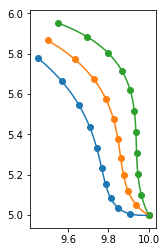

In [7]:
rx = [0.2,0.2,0.1]
ry = [0.3,0.4,1.0]
a_0,a_1,a_2 = pi/6,pi/6,pi/6
x_0,y_0 = 10,5
drawModel(x=rx,y=ry,CCtl=CPC,LCtl=CPL,RCtl=CPR,angle0=a_0,angle1=a_1,angle2=a_2,dx=x_0,dy=y_0)

⎛⎡       3        2                                     2⎤  ⎡                 
⎜⎢- 0.3⋅t  + 1.2⋅t ⋅(t - 1) - 3.97036631956645⋅t⋅(t - 1) ⎥  ⎢            -0.08
⎜⎢                                                       ⎥, ⎢                 
⎜⎢     3        2                                      2 ⎥  ⎢     3        2  
⎝⎣1.0⋅t  - 2.7⋅t ⋅(t - 1) + 0.506153423827593⋅t⋅(t - 1)  ⎦  ⎣1.0⋅t  - 2.7⋅t ⋅(

                        2            ⎤  ⎡     3        2                      
98500749821453⋅t⋅(t - 1)             ⎥  ⎢0.3⋅t  - 1.2⋅t ⋅(t - 1) + 3.790666169
                                     ⎥, ⎢                                     
                                    2⎥  ⎢     3        2                      
t - 1) + 0.895503748750223⋅t⋅(t - 1) ⎦  ⎣1.0⋅t  - 2.7⋅t ⋅(t - 1) + 1.284854073

               2⎤⎞
60216⋅t⋅(t - 1) ⎥⎟
                ⎥⎟
               2⎥⎟
67285⋅t⋅(t - 1) ⎦⎠

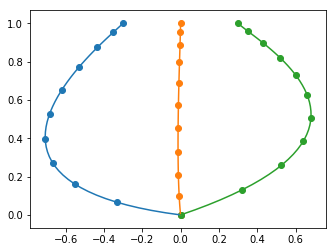

In [8]:
rx = [1.3,0.4,0.3]
ry = [0.3,0.9,1.0]
a_0,a_1,a_2 = 0,0.1,0
x_0,y_0 = 0,0
drawModel(x=rx,y=ry,CCtl=CPC,LCtl=CPL,RCtl=CPR,angle0=a_0,angle1=a_1,angle2=a_2,dx=x_0,dy=y_0)

In [20]:
# 制御点  
pcx,pcy = symbols('pcx:4'),symbols('pcy:4')
plx,ply = symbols('plx:4'),symbols('ply:4')
prx,pry = symbols('prx:4'),symbols('pry:4')
px0,px1,px2,px3 = symbols('px0,px1,px2,px3')
py1,py2,py3 = symbols('py1,py2,py3')
CPC = [[0,0],[0,py1],[0,py2],[0,py3]]
CPL = [[-px0,0],[-px1,py1],[-px2,py2],[-px3,py3]]
CPR = [[px0,0],[px1,py1],[px2,py2],[px3,py3]]
print('\n',CPC,'\n',CPL,'\n',CPR)


 [[0, 0], [0, py1], [0, py2], [0, py3]] 
 [[-px0, 0], [-px1, py1], [-px2, py2], [-px3, py3]] 
 [[px0, 0], [px1, py1], [px2, py2], [px3, py3]]


In [21]:
#  CPC0,CPC1,CPL0,CPL1,CPR0,CPR1が CPC0 周りに a1 ラジアン回転、
# CPC3,CPC2,CPL3,CPL2,CPR3,CPR2 が CPC3 周りに a2 ラジアン回転　（　曲がりのモデル）
a0,a1,a2 = symbols('a0,a1,a2') 
x0,y0 = symbols('x0,y0') 
#QPC0,QPC1,QPL0,QPL1,QPR0,QPR1 ,QPC3,QPC2,QPL3,QPL2,QPR3,QPR2  は一時的な作業用変数
[QPC0,QPC1,QPL0,QPL1,QPR0,QPR1] = rotationAll([CPC[0],CPC[1],CPL[0],CPL[1],CPR[0],CPR[1]],a1,CPC[0][0],CPC[0][1])
[QPC3,QPC2,QPL3,QPL2,QPR3,QPR2] = rotationAll([CPC[3],CPC[2],CPL[3],CPL[2],CPR[3],CPR[2]],a2,CPC[3][0],CPC[3][1])
CPC,CPL,CPR = [QPC0,QPC1,QPC2,QPC3],[QPL0,QPL1,QPL2,QPL3],[QPR0,QPR1,QPR2,QPR3]
#  # 制御点全体が (x0,y0)だけ平行移動し、 (x0,y0)を中心として a0 ラジアン回転した結果が観測されている
CPC = rotationAll(moveAll(CPC,x0,y0),a0,x0,y0)
CPL = rotationAll(moveAll(CPL,x0,y0),a0,x0,y0)
CPR = rotationAll(moveAll(CPR,x0,y0),a0,x0,y0)

In [23]:
CPL

# sympy のバグ注意

Matrix を使った時の simplify, expand はバグがあるみたいなので注意が必要。

In [9]:
f = 3*P0*t**2*(1-t)
y = f.subs(P0,Matrix([1,1]))
y

⎡3⎤  2         
⎢ ⎥⋅t ⋅(-t + 1)
⎣3⎦            

In [10]:
simplify(y)

⎡3⎤  2        
⎢ ⎥⋅t ⋅(t - 1)
⎣3⎦           

In [11]:
expand(y)

⎡3⎤  3   ⎡3⎤  2
⎢ ⎥⋅t  + ⎢ ⎥⋅t 
⎣3⎦      ⎣3⎦   